In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

#for json convertion
import ast


import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

In [2]:
# Load Data Sets
df1 = pd.read_csv('cleanData/cleanChargingDataNoNull.csv')
df2 = pd.read_csv('weather_burbank_airport.csv')

In [3]:
#control if data was loaded
print(df1.head())
print(df2.head())

   Unnamed: 0     id             connectionTime             disconnectTime  \
0        1151  52943  2018-10-09 14:26:40+00:00  2018-10-09 18:48:12+00:00   
1        1156  53111  2018-10-12 09:07:47+00:00  2018-10-12 14:58:22+00:00   
2        1157  53138  2018-10-15 05:46:28+00:00  2018-10-15 16:43:30+00:00   
3        1158  53213  2018-10-16 06:13:50+00:00  2018-10-16 14:03:42+00:00   
4        1159  53258  2018-10-16 14:29:34+00:00  2018-10-16 19:30:34+00:00   

            doneChargingTime  kWhDelivered  siteID  spaceID    stationID  \
0  2018-10-09 18:28:29+00:00        12.034       1  AG-1F01  1-1-193-825   
1  2018-10-12 13:46:28+00:00        14.289       1  AG-1F01  1-1-193-825   
2  2018-10-15 08:03:25+00:00         6.457       1  AG-1F01  1-1-193-825   
3  2018-10-16 09:11:45+00:00         7.416       1  AG-1F01  1-1-193-825   
4  2018-10-16 17:33:31+00:00         9.909       1  AG-1F01  1-1-193-825   

   userID_x     parkDuration  WhPerMile  kWhRequested  milesRequested  \
0

Feature Engineering to focus on the relevant data for clustering

1. Session Duration (minutes): Time between connectionTime and disconnectTime.
2. Charging Duration (minutes): Time between connectionTime and doneChargingTime.
3. Idle Duration (minutes): Time between doneChargingTime and disconnectTime.
4. Charging Efficiency (kWh per minute): kWhDelivered / Charging Duration.
5. User Inputs: Extract fields from the userInputs JSON object (e.g., kWhRequested, minutesAvailable).


In [4]:
#since the data is in a string-format, there must be a conversion to datetime before performing calculations on it
df1['connectionTime'] = pd.to_datetime(df1['connectionTime'])
df1['disconnectTime'] = pd.to_datetime(df1['disconnectTime'])
df1['doneChargingTime'] = pd.to_datetime(df1['doneChargingTime'])
#calculating the session duration in minutes
df1['session_duration'] = (df1['disconnectTime'] - df1['connectionTime']).dt.total_seconds() / 60
df1['charging_duration'] = (df1['doneChargingTime'] - df1['connectionTime']).dt.total_seconds() / 60
df1['idle_duration'] = (df1['disconnectTime'] - df1['doneChargingTime']).dt.total_seconds() / 60
df1['charging_efficiency'] = df1['kWhDelivered'] / (df1['charging_duration'] / 60)

In [5]:
features = df1[['session_duration', 'charging_duration', 'idle_duration', 'charging_efficiency', 'kWhDelivered']]

print(features.head())

   session_duration  charging_duration  idle_duration  charging_efficiency  \
0        261.533333         241.816667      19.716667             2.985898   
1        350.583333         278.683333      71.900000             3.076395   
2        657.033333         136.950000     520.083333             2.828916   
3        469.866667         177.916667     291.950000             2.500946   
4        301.000000         183.950000     117.050000             3.232074   

   kWhDelivered  
0        12.034  
1        14.289  
2         6.457  
3         7.416  
4         9.909  


Cleaning up the data in "features"

In [6]:
print(features.isnull().sum())  # Check for missing values in each column
print(np.isinf(features).sum())  # Check for infinite values

session_duration       0
charging_duration      0
idle_duration          0
charging_efficiency    0
kWhDelivered           0
dtype: int64
session_duration       0
charging_duration      0
idle_duration          0
charging_efficiency    0
kWhDelivered           0
dtype: int64


In [7]:
# Filter data for each garage
garage_a_df_filter = df1[df1['siteID'] == 1]
garage_b_df_filter = df1[df1['siteID'] == 2]

# Save each garage's data to a separate CSV file
garage_a_df_filter.to_csv('GarageA_data.csv', index=False)
garage_b_df_filter.to_csv('GarageB_data.csv', index=False)

print("CSV files created: 'GarageA_data.csv' and 'GarageB_data.csv'")

CSV files created: 'GarageA_data.csv' and 'GarageB_data.csv'


In [8]:
# Load new Data Sets
garage_a_df = pd.read_csv('GarageA_data.csv')
garage_b_df = pd.read_csv('GarageB_data.csv')

In [9]:
#since the data is in a string-format, there must be a conversion to datetime before performing calculations on it
garage_a_df['connectionTime'] = pd.to_datetime(garage_a_df['connectionTime'])
garage_a_df['disconnectTime'] = pd.to_datetime(garage_a_df['disconnectTime'])
garage_a_df['doneChargingTime'] = pd.to_datetime(garage_a_df['doneChargingTime'])
#calculating the session duration in minutes
garage_a_df['session_duration'] = (garage_a_df['disconnectTime'] - garage_a_df['connectionTime']).dt.total_seconds() / 60
garage_a_df['charging_duration'] = (garage_a_df['doneChargingTime'] - garage_a_df['connectionTime']).dt.total_seconds() / 60
garage_a_df['idle_duration'] = (garage_a_df['disconnectTime'] - garage_a_df['doneChargingTime']).dt.total_seconds() / 60
garage_a_df['charging_efficiency'] = garage_a_df['kWhDelivered'] / (garage_a_df['charging_duration'] / 60)

In [10]:
featuresA = garage_a_df[['session_duration', 'charging_duration', 'idle_duration', 'charging_efficiency', 'kWhDelivered']]

print(featuresA.head())
print(featuresA.isnull().sum())  # Check for missing values in each column
print(np.isinf(featuresA).sum())  # Check for infinite values

   session_duration  charging_duration  idle_duration  charging_efficiency  \
0        261.533333         241.816667      19.716667             2.985898   
1        350.583333         278.683333      71.900000             3.076395   
2        657.033333         136.950000     520.083333             2.828916   
3        469.866667         177.916667     291.950000             2.500946   
4        301.000000         183.950000     117.050000             3.232074   

   kWhDelivered  
0        12.034  
1        14.289  
2         6.457  
3         7.416  
4         9.909  
session_duration       0
charging_duration      0
idle_duration          0
charging_efficiency    0
kWhDelivered           0
dtype: int64
session_duration       0
charging_duration      0
idle_duration          0
charging_efficiency    0
kWhDelivered           0
dtype: int64


In [11]:
#since the data is in a string-format, there must be a conversion to datetime before performing calculations on it
garage_b_df['connectionTime'] = pd.to_datetime(garage_b_df['connectionTime'])
garage_b_df['disconnectTime'] = pd.to_datetime(garage_b_df['disconnectTime'])
garage_b_df['doneChargingTime'] = pd.to_datetime(garage_b_df['doneChargingTime'])
#calculating the session duration in minutes
garage_b_df['session_duration'] = (garage_b_df['disconnectTime'] - garage_b_df['connectionTime']).dt.total_seconds() / 60
garage_b_df['charging_duration'] = (garage_b_df['doneChargingTime'] - garage_b_df['connectionTime']).dt.total_seconds() / 60
garage_b_df['idle_duration'] = (garage_b_df['disconnectTime'] - garage_b_df['doneChargingTime']).dt.total_seconds() / 60
garage_b_df['charging_efficiency'] = garage_b_df['kWhDelivered'] / (garage_b_df['charging_duration'] / 60)

In [12]:
featuresB = garage_b_df[['session_duration', 'charging_duration', 'idle_duration', 'charging_efficiency', 'kWhDelivered']]

print(featuresB.head())
print(featuresB.isnull().sum())  # Check for missing values in each column
print(np.isinf(featuresB).sum())  # Check for infinite values

   session_duration  charging_duration  idle_duration  charging_efficiency  \
0        161.633333         150.000000      11.633333             3.387600   
1        236.900000          96.733333     140.166667             3.084562   
2        210.233333          91.083333     119.150000             3.099360   
3        316.566667         226.766667      89.800000             3.209202   
4        126.966667         126.883333       0.083333             3.351740   

   kWhDelivered  
0         8.469  
1         4.973  
2         4.705  
3        12.129  
4         7.088  
session_duration       0
charging_duration      0
idle_duration          0
charging_efficiency    0
kWhDelivered           0
dtype: int64
session_duration       0
charging_duration      0
idle_duration          0
charging_efficiency    0
kWhDelivered           0
dtype: int64


# Normalizing the data for clustering

In [13]:
scaler = StandardScaler()

#original dataset
scaled_features = scaler.fit_transform(features)

#parking site A
scaled_featuresA = scaler.fit_transform(featuresA)

#parking site B
scaled_featuresB = scaler.fit_transform(featuresB)

# Cluster Analysis

## kMean

### without differentiating between the sites

In [14]:
print(scaled_features.shape)  # Check the number of rows in scaled_features
print(df1.shape)  # Check the number of rows in df1

(38975, 5)
(38975, 24)


In [15]:
scaled_features_cleaned = scaled_features[~np.isinf(features['charging_efficiency']) & features['charging_efficiency'].notna()]

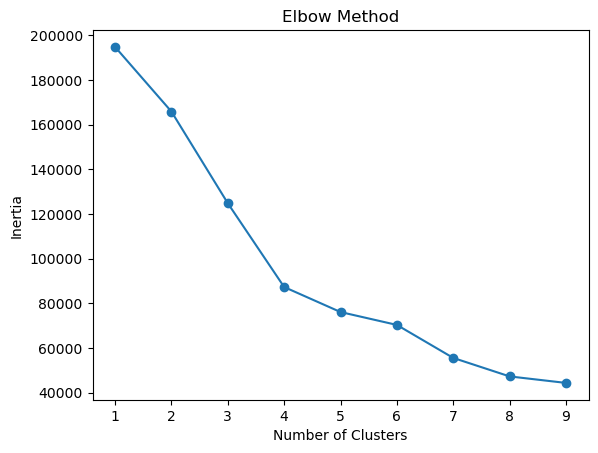

In [16]:
# Determine optimal number of clusters (Elbow Method)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features_cleaned)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

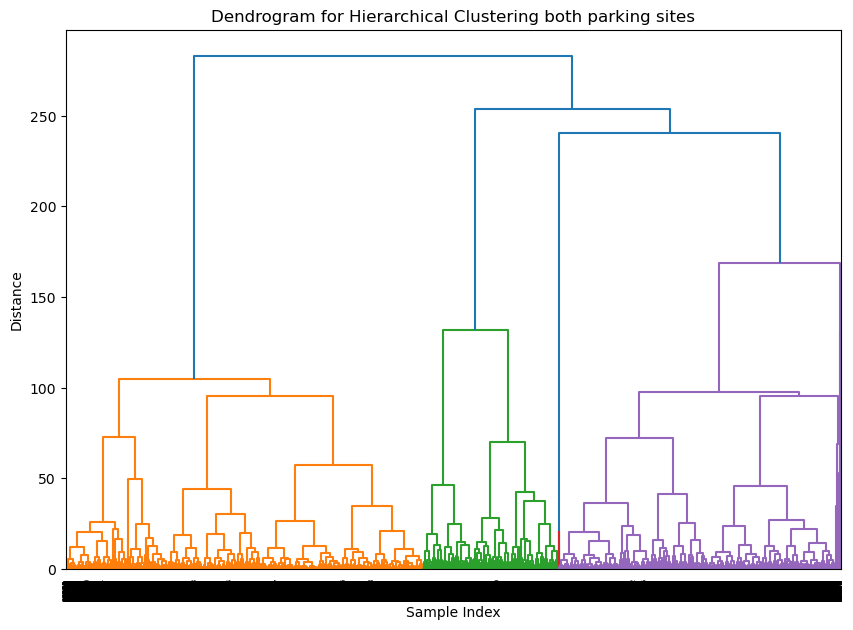

Cluster labels for each data point: [ 1  2 43 ... 19 20 19]


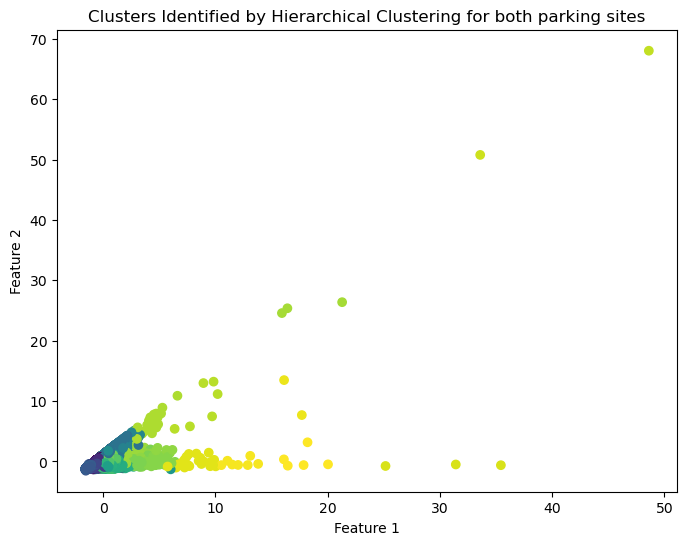

In [18]:
# Perform hierarchical/agglomerative clustering
Z = sch.linkage(scaled_features_cleaned, method='ward')  # 'ward' minimizes the variance of the clusters

# Plot the dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(Z)
plt.title("Dendrogram for Hierarchical Clustering both parking sites")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()


max_d = 15  # Adjust this value to cut the dendrogram at a certain height
clusters = fcluster(Z, max_d, criterion='distance')

# Print the clusters for each data point
print("Cluster labels for each data point:", clusters)

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(scaled_features_cleaned[:, 0], scaled_features_cleaned[:, 1], c=clusters, cmap='viridis')
plt.title("Clusters Identified by Hierarchical Clustering for both parking sites")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


#### Interpretation of the plots

The elbow plot shows a pronounced bend at "number of clusters" = 4. The dendogram also displays 4 clusters, therefore the amount of clusters will be set to 4 in the next step.

In [19]:
# Apply KMeans with optimal clusters
# Apply KMeans clustering with optimal number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)
featuresNew = features.copy()
featuresNew['cluster'] = kmeans.fit_predict(scaled_features)

In [20]:
cluster_summary = featuresNew.groupby('cluster').mean()
print(cluster_summary)

         session_duration  charging_duration  idle_duration  \
cluster                                                       
0              196.647672         144.088317      52.559355   
1              803.938889          -0.700000     804.638889   
2              571.466923         191.053029     380.413895   
3              543.725567         452.441673      91.283894   

         charging_efficiency  kWhDelivered  
cluster                                     
0                   4.039913      9.154302  
1                -351.655586      4.297557  
2                   3.179722      9.571519  
3                   4.172778     29.059150  


#### Visualize data with scatterplot

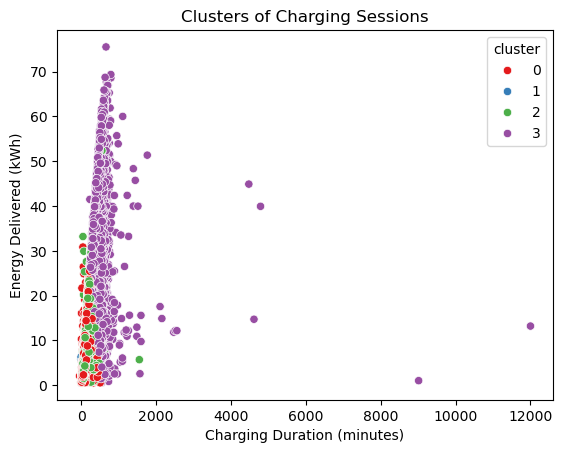

In [21]:
sns.scatterplot(data=featuresNew, x='charging_duration', y='kWhDelivered', hue='cluster', palette='Set1')
plt.title('Clusters of Charging Sessions')
plt.xlabel('Charging Duration (minutes)')
plt.ylabel('Energy Delivered (kWh)')
plt.show()

### For site 1

In [22]:
print(scaled_featuresA.shape)  # Check the number of rows in scaled_featuresA
print(garage_a_df.shape)  # Check the number of rows in garage A

(26152, 5)
(26152, 24)


In [23]:
scaled_features_cleanedA = scaled_featuresA[~np.isinf(garage_a_df['charging_efficiency']) & garage_a_df['charging_efficiency'].notna()]

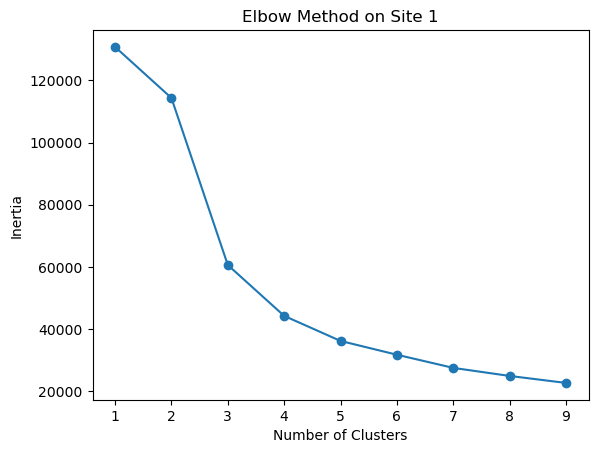

In [24]:
# Determine optimal number of clusters (Elbow Method)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features_cleanedA)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method on Site 1')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

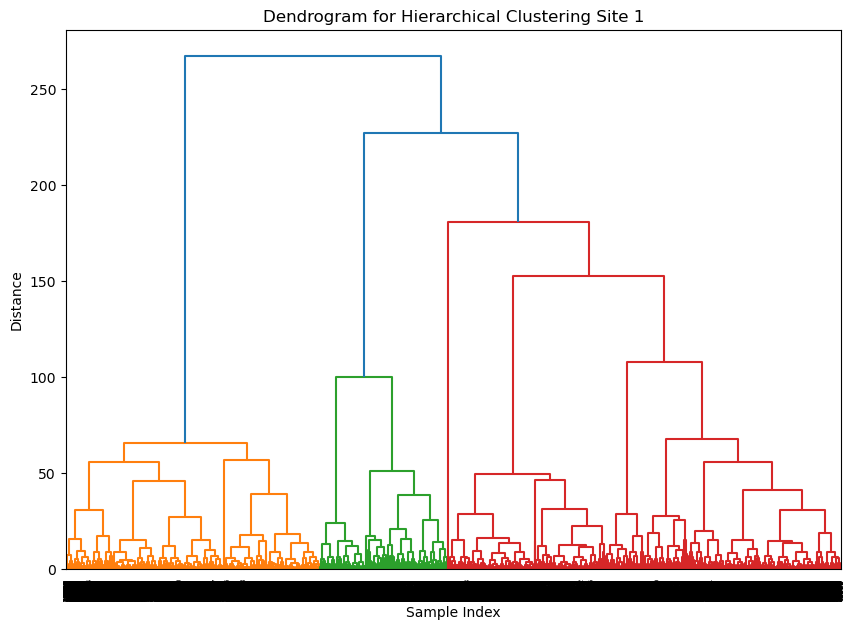

Cluster labels for each data point: [ 6 41 30 ...  5  2 46]


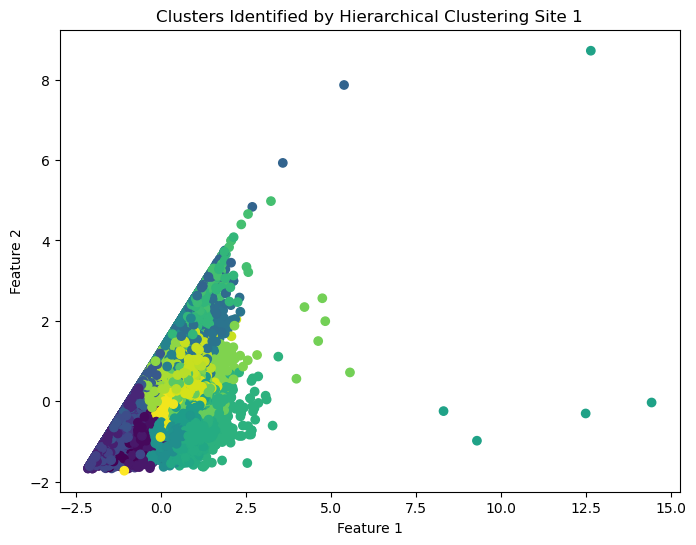

In [26]:
# Perform hierarchical/agglomerative clustering
Z = sch.linkage(scaled_features_cleanedA, method='ward')  # 'ward' minimizes the variance of the clusters

# Plot the dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(Z)
plt.title("Dendrogram for Hierarchical Clustering Site 1")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()


max_d = 15  # Adjust this value to cut the dendrogram at a certain height
clusters = fcluster(Z, max_d, criterion='distance')

# Print the clusters for each data point
print("Cluster labels for each data point:", clusters)

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(scaled_features_cleanedA[:, 0], scaled_features_cleanedA[:, 1], c=clusters, cmap='viridis')
plt.title("Clusters Identified by Hierarchical Clustering Site 1")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

#### Interpretation of the plot

The elbow plot shows a pronounced bend at "number of clusters" = 3. The dendogram also displays3 clusters, therefore the amount of clusters will be set to 3 in the next step.

In [27]:
# Apply KMeans with optimal clusters
# Apply KMeans clustering with optimal number of clusters
kmeansA = KMeans(n_clusters=3, random_state=42)
garageACopy = featuresA.copy()
garageACopy['cluster'] = kmeansA.fit_predict(scaled_featuresA)

In [28]:
cluster_summaryA = garageACopy.groupby('cluster').mean()
print(cluster_summaryA)

         session_duration  charging_duration  idle_duration  \
cluster                                                       
0              208.580559         159.041371      49.539188   
1              544.100176         462.152234      81.947942   
2              569.772577         216.766628     353.005949   

         charging_efficiency  kWhDelivered  
cluster                                     
0                   4.070481     10.436616  
1                   4.112372     30.082172  
2                   2.960824     10.425152  


#### Visualize data with scatterplot

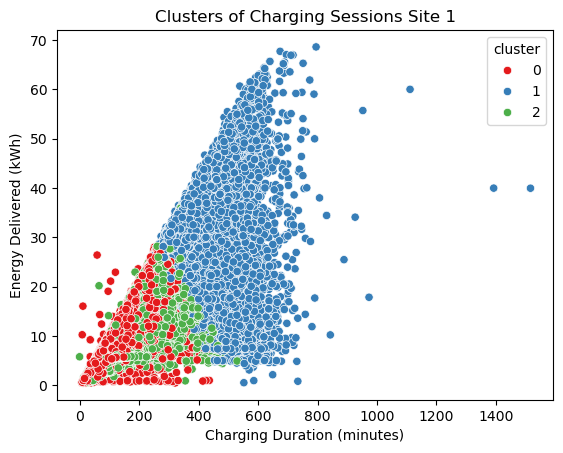

In [29]:
sns.scatterplot(data=garageACopy, x='charging_duration', y='kWhDelivered', hue='cluster', palette='Set1')
plt.title('Clusters of Charging Sessions Site 1')
plt.xlabel('Charging Duration (minutes)')
plt.ylabel('Energy Delivered (kWh)')
plt.show()

### For site 2

In [30]:
print(scaled_featuresB.shape)  # Check the number of rows in scaled_featuresB
print(garage_b_df.shape)  # Check the number of rows in garage B

(12823, 5)
(12823, 24)


In [31]:
scaled_features_cleanedB = scaled_featuresB[~np.isinf(garage_b_df['charging_efficiency']) & garage_b_df['charging_efficiency'].notna()]

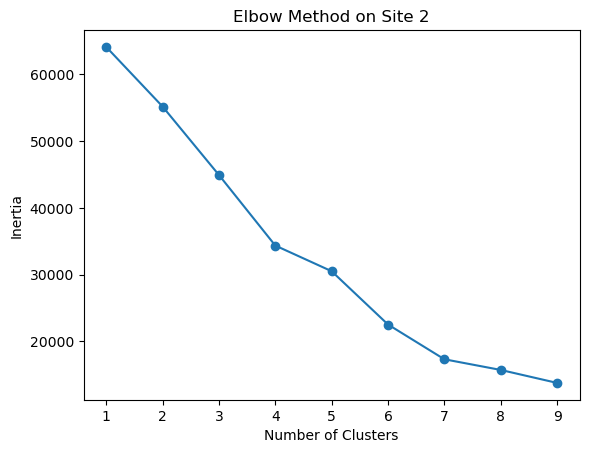

In [32]:
# Determine optimal number of clusters (Elbow Method)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features_cleanedB)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method on Site 2')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

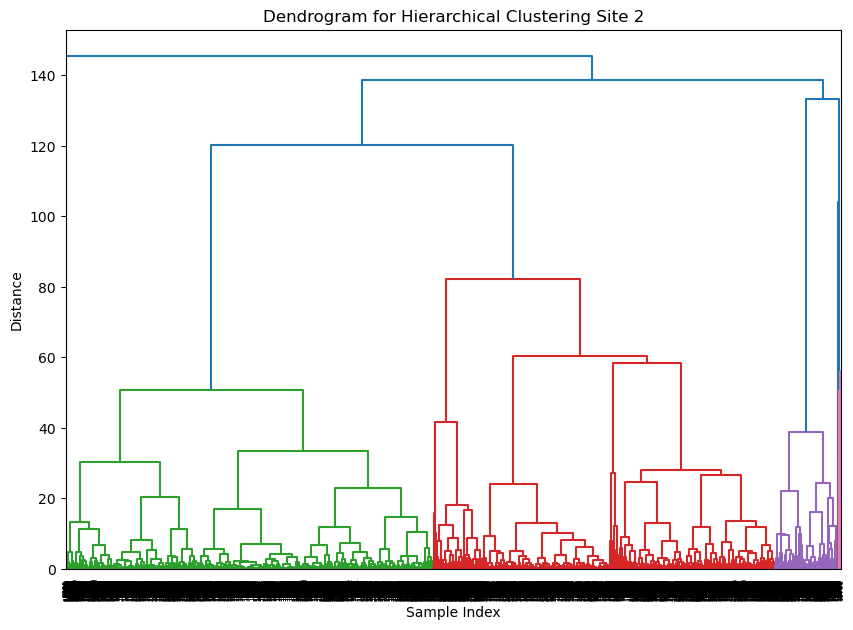

Cluster labels for each data point: [8 8 8 ... 7 4 7]


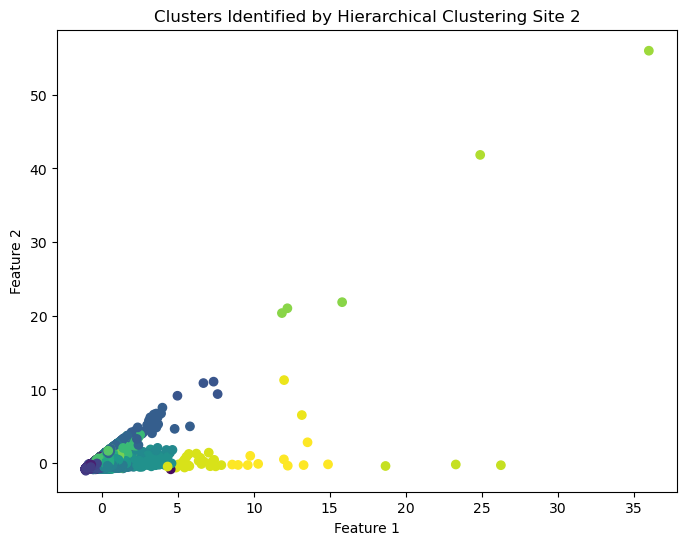

In [33]:
# Perform hierarchical/agglomerative clustering
Z = sch.linkage(scaled_features_cleanedB, method='ward')  # 'ward' minimizes the variance of the clusters

# Plot the dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(Z)
plt.title("Dendrogram for Hierarchical Clustering Site 2")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()


max_d = 15  # Adjust this value to cut the dendrogram at a certain height
clusters = fcluster(Z, max_d, criterion='distance')

# Print the clusters for each data point
print("Cluster labels for each data point:", clusters)

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(scaled_features_cleanedB[:, 0], scaled_features_cleanedB[:, 1], c=clusters, cmap='viridis')
plt.title("Clusters Identified by Hierarchical Clustering Site 2")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

#### Interpretation of the plot

The plot shows a pronounced bend at "number of clusters" = 4. The dendogram also displays 4 clusters, therefore the amount of clusters will be set to 4 in the next step

In [34]:
# Apply KMeans with optimal clusters
# Apply KMeans clustering with optimal number of clusters
kmeansB = KMeans(n_clusters=4, random_state=42)
garageBCopy = featuresB.copy()
garageBCopy['cluster'] = kmeansB.fit_predict(scaled_featuresB)

In [35]:
cluster_summaryB = garageBCopy.groupby('cluster').mean()
print(cluster_summaryB)

         session_duration  charging_duration  idle_duration  \
cluster                                                       
0              578.154692         135.377016     442.777676   
1              204.235207         144.160493      60.074714   
2              582.625158         440.040918     142.584239   
3             1098.375000          -0.566667    1098.941667   

         charging_efficiency  kWhDelivered  
cluster                                     
0                   3.640241      8.053781  
1                   3.838634      7.723502  
2                   4.898878     29.873014  
3                -347.390276      3.544836  


#### Visualize data with scatterplot

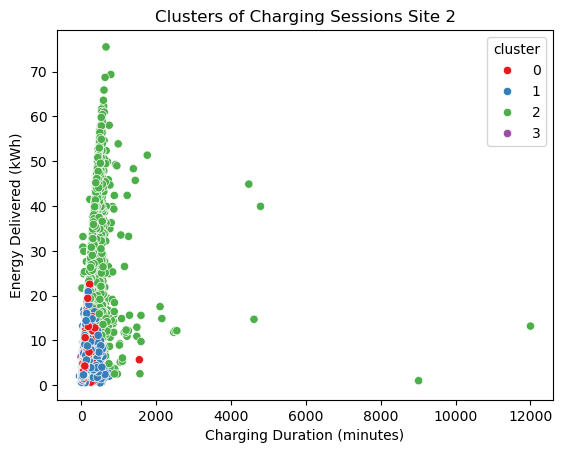

In [36]:
sns.scatterplot(data=garageBCopy, x='charging_duration', y='kWhDelivered', hue='cluster', palette='Set1')
plt.title('Clusters of Charging Sessions Site 2')
plt.xlabel('Charging Duration (minutes)')
plt.ylabel('Energy Delivered (kWh)')
plt.show()